# **HW2** 

### **Import**

In [ ]:
!pip install --upgrade pip
!pip install torchmetrics
!pip install torchmetrics timm
!pip install -U git+https://github.com/albu/albumentations > /dev/null
!pip install albumentations==0.4.6

     |████████████████████████████████| 1.6MB 3.9MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 271 kB 3.9 MB/s 
     |████████████████████████████████| 287 kB 3.7 MB/s 
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-7m89n4q5
     |████████████████████████████████| 117 kB 3.9 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65161 sha256=b5d2c76b9c95da852740a621d7cc11e5e84226ee0a3239e8e67e4e53974e949e
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.5.2
    Uninstalling albumentations-0.5.2:
      Successfully uninstalled albumentations-0.5.2


In [ ]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import glob
import matplotlib.pyplot as plt
import os
import torchmetrics
import timm
from scipy.signal import  convolve2d
from PIL import Image
import sys
from google.colab.patches import cv2_imshow

import cv2
from   cv2 import imread

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from   torch.utils.data import Dataset , DataLoader
from   torch.autograd import Variable

import torchvision
from   torchvision import datasets, models, transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
class_img_path = '/content/drive/MyDrive/Afeka_CV_2021'   # Path link

Mounted at /content/drive


## **Task 1**

In [ ]:
class load_data(Dataset):
  def __init__(self, path = class_img_path):
    self.images = []
    counter = 0 # Counts all images
    for dir in os.listdir(path):
      plt.figure(figsize=(20, 16))
      current_path = path + '/' + dir
      print(f'Reads from: {dir}')
      i=0 # Counts every dir's images
      for image in os.listdir(current_path): 
        self.images.append((current_path + '/' + image, dir)) # tupple with (img dir, target)
        plt.subplot((len(os.listdir(current_path))%5) + len(os.listdir(current_path))/5, 5, i+1)
        img, target = self.__getitem__(counter) 
        plt.title(target)
        plt.imshow(img) # Prints current image
        i += 1 
        counter += 1

  # Task 1.1, 1.2
  def __call__(self):
    random.shuffle(self.images) # Shuffles the images
    idx = int(len(self.images) * 0.8)
    self.train = self.images[:idx]
    self.test = self.images[idx+1:]
    X_train = [x[0] for x in self.train]
    y_train = [x[1] for x in self.train]
    X_test = [x[0] for x in self.test]
    y_test = [x[1] for x in self.test]
    return (X_train, y_train), (X_test, y_test)

  # Prints all class's images - Will not be in use.
  def print_pictures(self):
    plt.figure(figsize=(20, 16))
    for i in range(10):
      rnd = random.randint(0, len(self.images)-1)
      plt.subplot(len(self.images)/4, 4, i+1)
      img, target = self.__getitem__(i) 
      plt.title(target)
      plt.imshow(img)

  def __getitem__(self, idx):
    img, target = self.images[idx]
    img = cv2.cvtColor(cv2.imread(img), cv2.COLOR_RGB2BGR)
    return img, target

  def random_image(self):
    idx = random.randint(0, len(self.images) - 1)
    img, target = self.__getitem__(idx)
    return img

#### **Data loading and printing all images**

In [ ]:
data = load_data()
(x_train, y_train), (x_test, y_test) = data()

### **Choosing Agumentations**
Now we will decide which agumentations will be used.

* Will be used:
 * `Sharpening` -  may help us find the face more clearly.
 * `Horizonal Flip` - face is a face even if we see him like a "mirror".
 * `Rotate` - (Limited angels), the face might not be in the right position to be recognized, so slight angle changing can be helpful.

* Will **not** be used
 * `Gaussian Blur` and `Median Blur` - may earase relevant features of the face.
 * `Zoom` and `Crop` - may cut out face's features.
 * `Vertical Flip` and (unlimited) `Rotate` - for most angles and for vertical flip, the face might not be recognized.

#### **Agumentations's Functions**

##### **Helpers**

In [ ]:
# Helping matrixes
sobelX = np.asarray(([-1, 0, 1], [-2, 0, 2], [-1, 0, 1]), dtype=np.float32) * 1/16
sobelY = np.asarray(([-1,-2,-1], [0, 0, 0], [1, 2, 1]), dtype=np.float32) * 1/16
laplacian = np.array(([0, -1, 0], [-1, 5, -1], [0, -1, 0]), dtype='int') * 0.25 

mats = [sobelX, sobelY, laplacian]

# Calculates padding
def calculate_padding_single_dim(dim_in, dim_out, kernel_size):
  return  int(np.ceil((dim_out - dim_in + kernel_size) /2 ) -1)

##### **Agumentations's Functions**

###### Sharpaning

In [ ]:
def sharp_img(img, kernel=laplacian):
  sharpened_img = convolve2d(img, kernel) # img convolation with matrix
  return np.abs(sharpened_img) # values are positive

###### Rotation

In [ ]:
def rotate(img: np.ndarray, angle: int):
  h, w = img.shape[0], img.shape[1]
  res_img = np.zeros(img.shape) # New image creation
  # Angle's calculations
  angle = np.deg2rad(angle)
  cos_a = np.cos(angle)
  sin_a = np.sin(angle)
  # Image's center
  midY = round(((h + 1) / 2) - 1)
  midX = round(((w + 1) / 2) - 1)
  # Result's center
  yCenter = round((midY * cos_a) - (midX * sin_a))
  xCenter = round((midY * sin_a) + (midX * cos_a))

  for y in range(h):
    for x in range(w):
      nX = round((y * sin_a) + (x * cos_a)) - xCenter + midX
      nY = round((y * cos_a) - (x * sin_a)) - yCenter + midY
      if (w > nX and (nX > 0)) and (h > nY and (nY > 0)):
        res_img[nY ,nX] = img[y ,x]
  
  return res_img.astype(np.uint8)

###### Horizontal Flip

In [ ]:
def horizontal_flip(img):
  f_img = img[:, ::-1, :]
  return f_img

##### **Example on the Data**

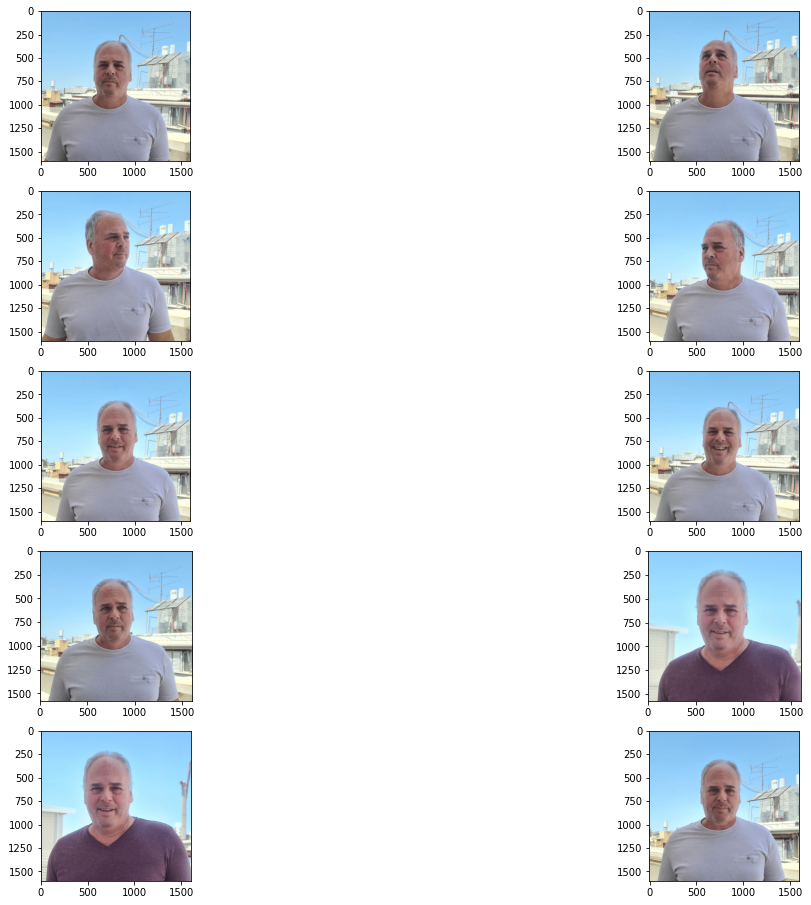

In [ ]:
examples_paths = ['/content/drive/MyDrive/Afeka_CV_2021/StavRabinovich/1.png',
'/content/drive/MyDrive/Afeka_CV_2021/StavRabinovich/2.png','/content/drive/MyDrive/Afeka_CV_2021/StavRabinovich/3.png',
'/content/drive/MyDrive/Afeka_CV_2021/StavRabinovich/4.png','/content/drive/MyDrive/Afeka_CV_2021/StavRabinovich/5.png',
'/content/drive/MyDrive/Afeka_CV_2021/StavRabinovich/6.png','/content/drive/MyDrive/Afeka_CV_2021/StavRabinovich/7.png',
'/content/drive/MyDrive/Afeka_CV_2021/StavRabinovich/8.png','/content/drive/MyDrive/Afeka_CV_2021/StavRabinovich/9.png',
'/content/drive/MyDrive/Afeka_CV_2021/StavRabinovich/10.png']

def create_examples(npp = False):
  examples_imgs = []
  for i in range(len(examples_paths)):
    if npp:
      examples_imgs.append(np.array(Image.open(examples_paths[i])))
    else:
      examples_imgs.append(cv2.cvtColor(cv2.imread(examples_paths[i]), cv2.COLOR_RGB2BGR))
  return examples_imgs

def print_imgs(ex_imgs):
  plt.figure(figsize=(20, 16))
  for i in range(len(ex_imgs)):
    plt.subplot(len(ex_imgs)/2, 2, i+1)
    plt.imshow(ex_imgs[i])

def results_print(arg_results):
  examples_imgs = create_examples()
  final_res = []
  for i in range(len(examples_imgs)):
    final_res.append(examples_imgs[i])
    final_res.append(arg_results[i])
  print_imgs(final_res)

print_imgs(create_examples())

###### Sharpaning

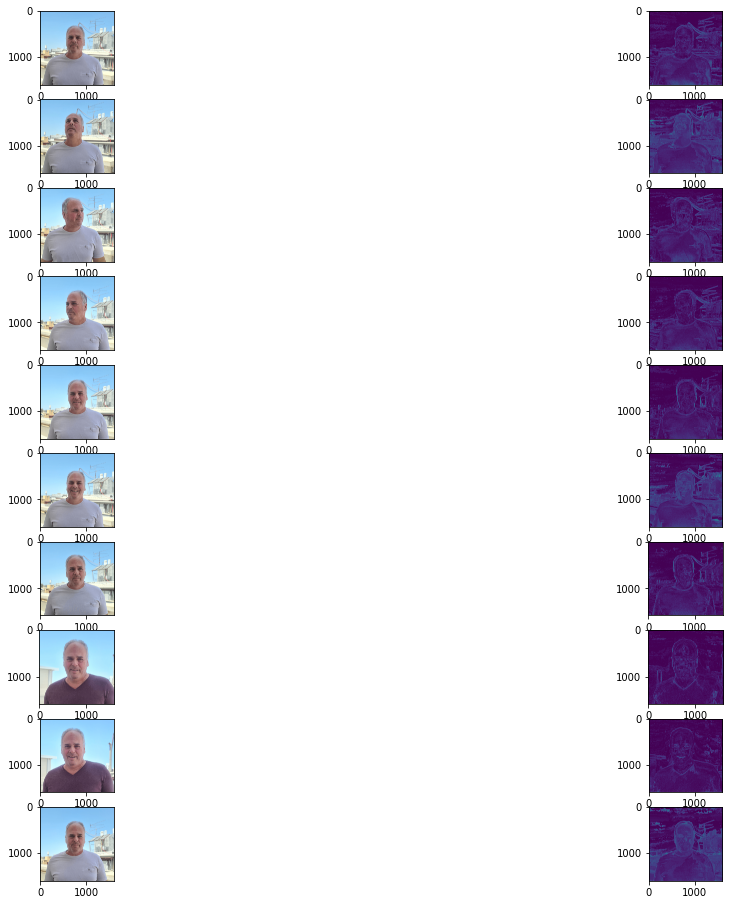

In [ ]:
exmpls = create_examples(npp = True)
ex_sharp = []
for img in exmpls:
  ex_sharp.append(sharp_img(img, kernel=mats[random.randint(0,len(mats)-1)]))

results_print(ex_sharp)

###### Rotation

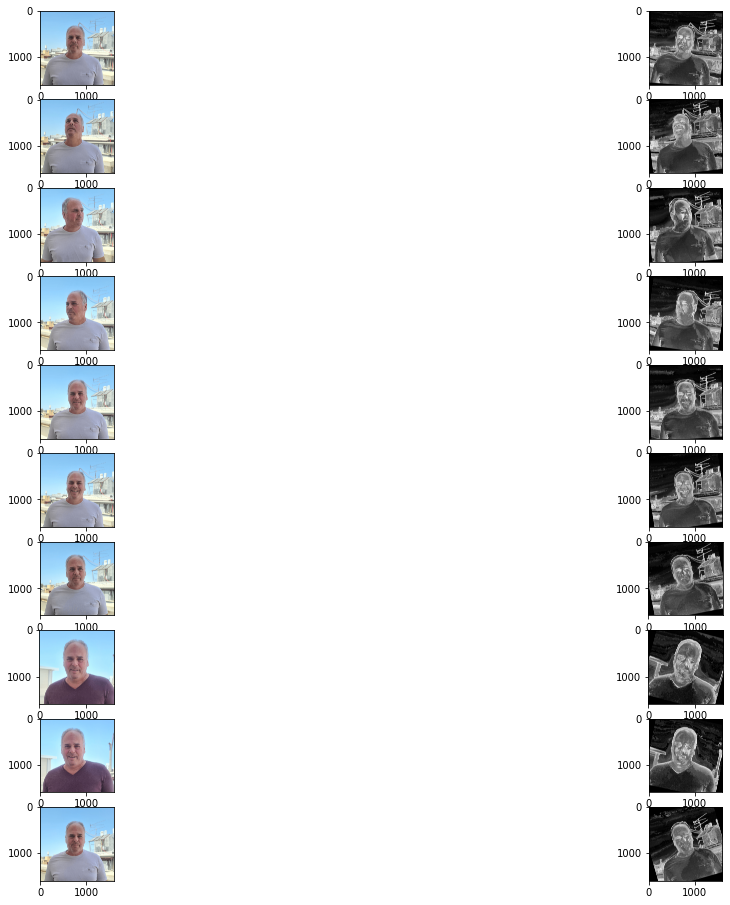

In [ ]:
angles = [-20, 20]
exmpls = create_examples(npp = True)
ex_rot = []

for img in exmpls:
  ex_rot.append(cv2.cvtColor(rotate(img, angle=random.randint(angles[0], angles[1])), cv2.COLOR_GRAY2BGR))

results_print(ex_rot)

###### Horizontal Flip

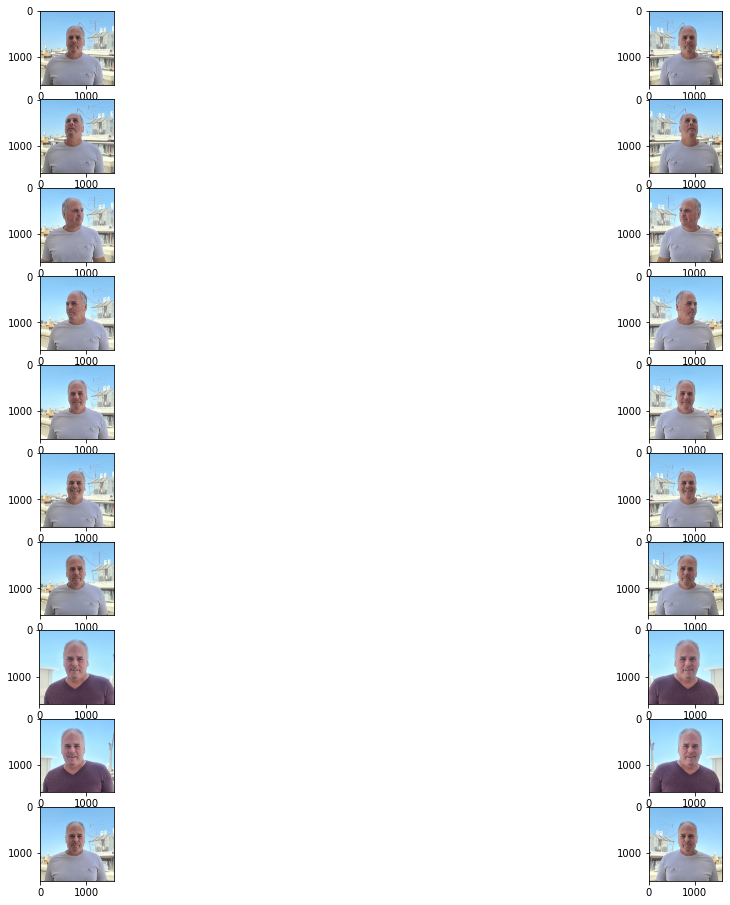

In [ ]:
exmpls = create_examples()
ex_hor = []

for img in exmpls:
  ex_hor.append(horizontal_flip(img))

results_print(ex_hor)

###### Mixed

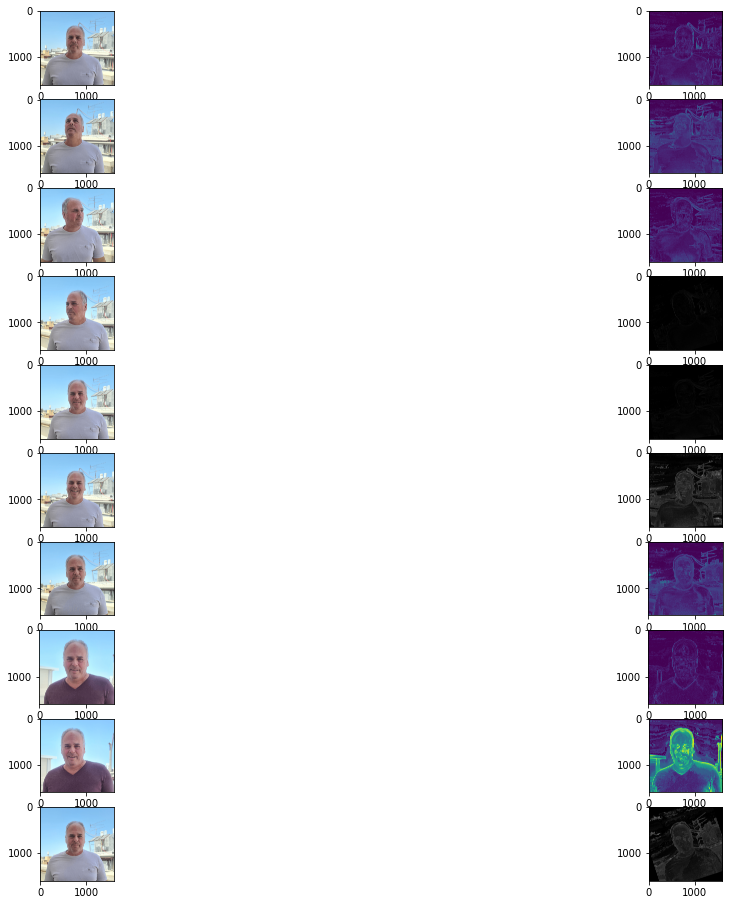

In [ ]:
exmpls = create_examples(npp = True)
ex_mixed = []

for img in exmpls:
  rnd = random.randint(0,3) # 0: None       1: sharp     2: rotate     3: sh + ro 
  n_img = img
  if rnd in [1, 3]: # Sharp
    n_img = sharp_img(n_img, kernel=mats[random.randint(0,len(mats)-1)])
  if rnd in [2, 3]: # Rotate
    n_img = cv2.cvtColor(rotate(n_img, angle=random.randint(angles[0], angles[1])), cv2.COLOR_BGR2RGB)
  ex_mixed.append(n_img)

results_print(ex_mixed)

## **Task 2**

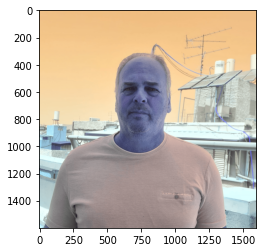

In [ ]:
faceCascade = cv2.CascadeClassifier()
test_path = '/content/drive/MyDrive/Afeka_CV_2021/StavRabinovich/1.png'
image = cv2.imread(test_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# image = cv2.cv2(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [ ]:
path_img1 = '/content/drive/MyDrive/Afeka_CV_2021/StavRabinovich/1.png'
path_img2 = '/content/drive/MyDrive/Afeka_CV_2021/Nadav_Shaoulian/Nadav6.jpg'

### Reading first image and dectating where the face is



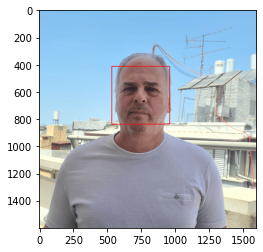

In [ ]:
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
# Read the image
image1 = cv2.imread(path_img1)
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect faces in the image
faces1 = faceCascade.detectMultiScale(
    gray,
    scaleFactor=1.1,
    minNeighbors=5,
    minSize=(30, 30),
    flags=cv2.CASCADE_SCALE_IMAGE
)

# Draw a rectangle around the faces
for (x, y, w, h) in faces1:
    cv2.rectangle(image1, (x, y), (x + w, y + h), (255, 0, 0), 4)

plt.imshow(image1)

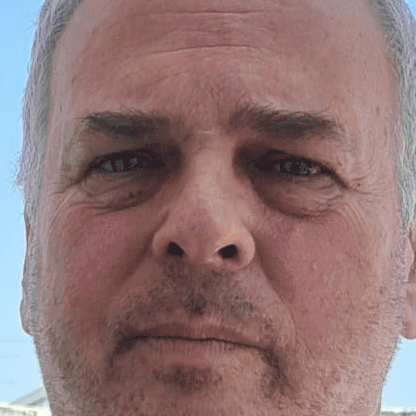

In [ ]:
box1 = image1[faces1[0][1]+4:faces1[0][1]+faces1[0][2]-4, faces1[0][0]+4:faces1[0][0]+faces1[0][3]-4] # remove red border -4
box1 = cv2.cvtColor(box1, cv2.COLOR_BGR2RGB)
cv2_imshow(box1)

### Reading 2nd image and dectating where the face is

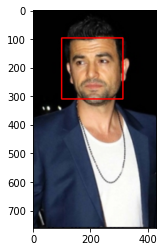

In [ ]:
image2 = cv2.imread(path_img2)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

# Detect faces in the image
faces2 = faceCascade.detectMultiScale(
    gray2,
    scaleFactor=1.1,
    minNeighbors=5,
    minSize=(30, 30),
    flags=cv2.CASCADE_SCALE_IMAGE
)

# Draw a rectangle around the faces
for (x, y, w, h) in faces2:
    cv2.rectangle(image2, (x, y), (x + w, y + h), (255, 0, 0), 4)

plt.imshow(image2)

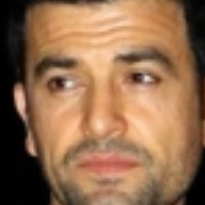

In [ ]:
box2 = image2[faces2[0][1]+4:faces2[0][1]+faces2[0][2]-4, faces2[0][0]+4:faces2[0][0]+faces2[0][3]-4] #r emove red border -4
box2 = cv2.cvtColor(box2, cv2.COLOR_BGR2RGB)
cv2_imshow(box2)

### **The swap**

In [ ]:
box1.shape
box2.shape

(205, 205, 3)

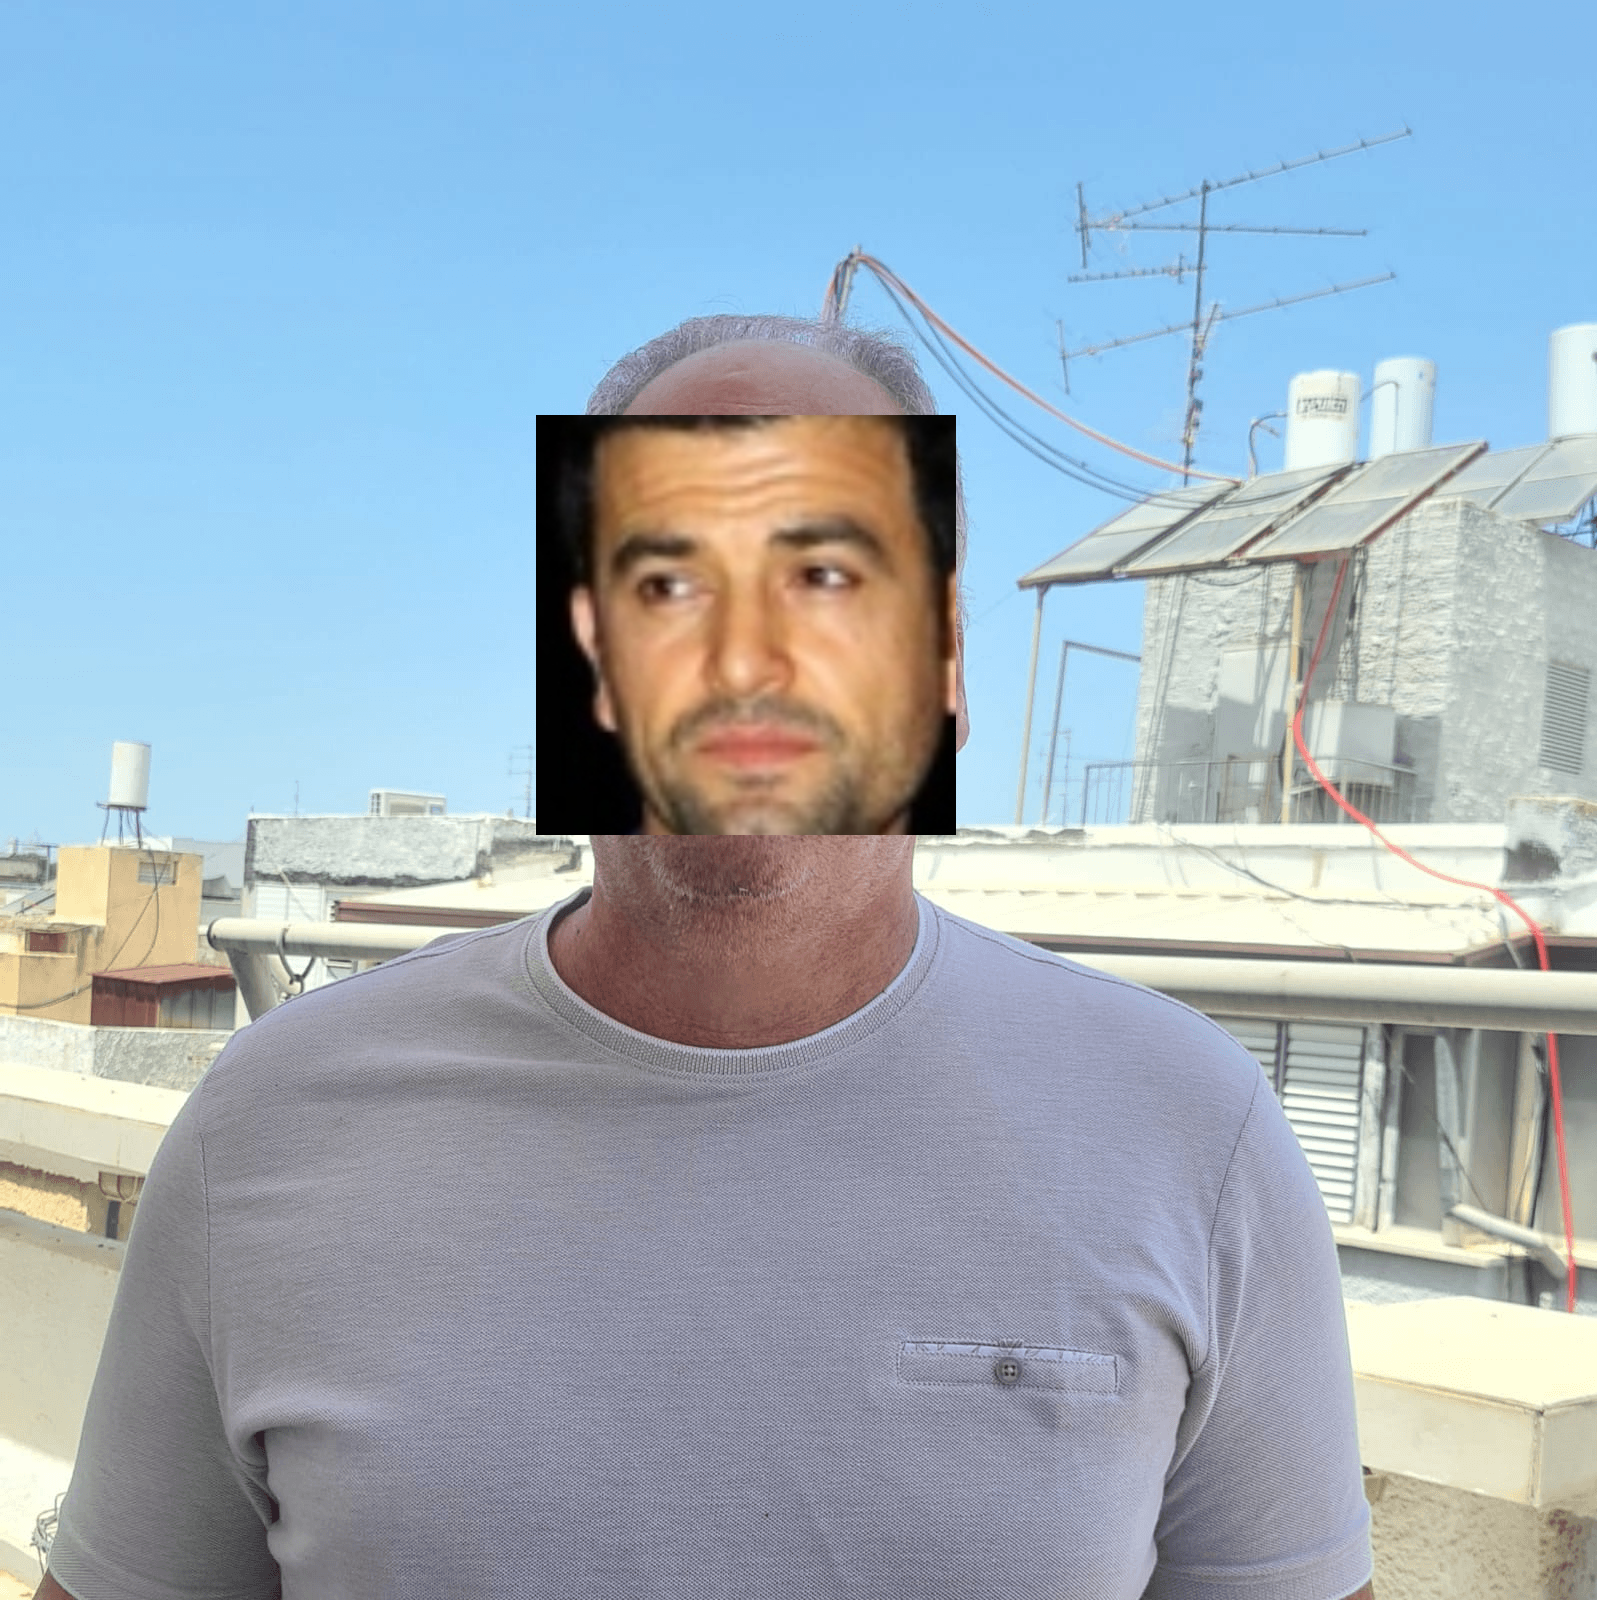

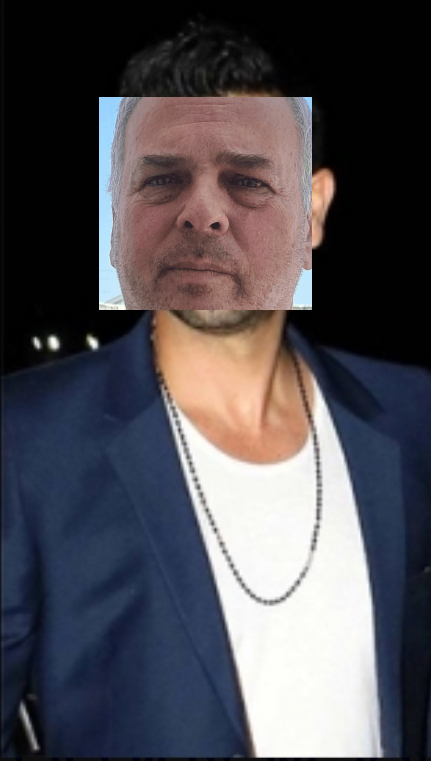

In [ ]:
def swap_faces(img1, img2):
  #gray images for face recognition
  gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
  gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
  #face recognition
  faces1 = faceCascade.detectMultiScale(gray1, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)
  faces2 = faceCascade.detectMultiScale(gray2, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)
  #get faces image
  box1 = img1[faces1[0][1]:faces1[0][1]+faces1[0][2], faces1[0][0]:faces1[0][0]+faces1[0][3]] # remove red border -4
  box1 = cv2.cvtColor(box1, cv2.COLOR_BGR2RGB)
  box2 = img2[faces2[0][1]:faces2[0][1]+faces2[0][2], faces2[0][0]:faces2[0][0]+faces2[0][3]] #r emove red border -4
  box2 = cv2.cvtColor(box2, cv2.COLOR_BGR2RGB)
  #reshape each face image to targets faces size
  resize_box2 = cv2.resize(box2, (box1.shape[0],box1.shape[1]))
  resize_box1 = cv2.resize(box1, (box2.shape[0],box2.shape[1]))
  #set colors
  img2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
  img1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
  # swap
  img1[faces1[0][1]:faces1[0][1]+faces1[0][2], faces1[0][0]:faces1[0][0]+faces1[0][3]] = resize_box2
  img2[faces2[0][1]:faces2[0][1]+faces2[0][2], faces2[0][0]:faces2[0][0]+faces2[0][3]]= resize_box1

  return img1, img2  


image2 = cv2.imread(path_img2)
image1 = cv2.imread(path_img1)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
img1, img2 = swap_faces(image1, image2)
cv2_imshow(img1)
cv2_imshow(img2)

## **TL;DR**

In this HW, we used the knowledge of data loading from previous labs, to create our own datasets from all known pictures. Later, we printed those pictures and used agumentations that might be helpful for dectating faces in picture.

On the 2nd part, we used `faceCascade` to dectate where the face is in two images, and later we switched faces between two images.
